# SPHERIC 2023 Code example
This notebook is meant to demonstrate how we can run an SPH simulation in pytorch, use this data directly to train a neural network and then directly include the neural network back into the simulation. This also shows how easy it is to run the same code on GPU and CPU.

Before proceeding further, however, we first need to install some necessary libraries that are not included in Google colab by default (these are used for the neighborhood search)

In [1]:
# import torch
# print(torch.__version__)
# print(torch.cuda.is_available())
# !pip install torch-geometric

In [2]:
# sph related imports
from sph import *
from perlin import *
# neural network rlated imports
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
from plotting import *
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
%matplotlib notebook

# Initial particle density sampling
First we setup the initial distribution of the particles. This is done by defining a PDF (probability density function) which is later used to sample particles such that the resulting density field is equal to the PDF.

Note that to be useful the pdf should always be greater than 0, e.g., it may b useful to shift a pdf you want to sample by a constant factor.

Different PDFs are included here and you should paste the one you want into the field below to use it:

### Sinusoidal Sampling
This is a simple sampling with 4 peaks in the $[-1,1]$ domain. This pdf is shifted by 2 with an intensity of 1 on the sinusoidal wave, i.e., the minimum density is 1 and the maximum density is 3.
```python
pdf = lambda x: np.sin(x * np.pi * 4) + 2
```
### Low Frequency Sinusoidal Sampling
This sinusoidal sampling is of a lower frequency, i.e. there is only a single peak in the domain $[-1,1]$ but this is mostly to show an alternative way to define a pdf by using linear interpolation of an arbitrary set of datapoints.
```python
noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```
### Square profile
This profile has a peak over $[-\frac{1}{3},\frac{1}{3}]$ where the density is at 2 and 1 everywhere else. This is useful to create a single well defined wave. 
```python
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
```
### Sawtooth profile
This profile creates a discontinuous profile where the sampled density changes from $2$ to $1$ at $x=0$ instantly and linearly ramps between these valus, creating a sawtooth profile.
```python
def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1
```
### Sharp Sawtooth profile
This profile has a discontinuity at $x=-1$ where the sampled density changes from $2$ to $0$. This 0 density is interesting but should be avoided due to the sampling we use.
```python
pdf = lambda x: 1 + x
```
### Triangular profile
This profile has a peak at $x=0$ with a density of $2$ and linarly ramps to $1$ at the edges of the domain
```python
pdf = lambda x: np.abs(x) + 1
```
### Gaussian profile
This profile is a smoothed variant of th above, change the standard deviation (the $8$) to change how broad the profile is.
```python
pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
```
### Uniform profile
This profile is mostly useful for debugging as nothing should happen in this case.
```python
pdf = lambda x: np.ones_like(np.array(x))
```
### Random profile
This profile uses a periodic noise generation, using Perlin noise, to create an octav noise that can be used to generate a lot of different samplings with high frequency components that are still somewhat _smooth_
```python
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```

In [181]:
numParticles = 2048 # Modify th number of desird particles here, this value is defined here to ensure that the linar sampling for some pdfs is accurate.
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 2, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
# pdf = lambda x: np.ones_like(np.array(x))

# Setup of simulation parameters

Before running the simulation we need to setup some necessary physical parameters:

Parameter | Default | Meaning
---|---|---
minDomain | -1 | The minimum extent of the simulation domain, should be left at -1
maxDomain | 1  | The maximum extent of the simulation domain, should be left at -1
baseArea | 2 / numParticles * 2 | The area (or length) represented by a single particle set based on the simulation domain size and particle count
particleSupport | particlRadius * 8. | The support radius, reducing this value makes the simulations sharper but also less stable so change with caution
xsphConstant | 0.0 | Diffusion coefficient for the XSPH velocity diffusion term. Used as an artificial viscosity but superceeded by the dynamic viscosity
diffusionAlpha | 1.0 | Diffusion coefficient for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
diffusionBeta | 2.0 | Diffusion coefficient for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
c0 | 10 | Speed of sound, used for a standard SPH velocity diffusion, based on Price 2010: https://arxiv.org/pdf/1012.1885.pdf
kappa | 10 | Coefficient for the ideal gas EOS
restDensity | 1000 | Coefficient for the ideal gas EOS
dt | 1e-3 | Fixed timestep used for the simulation

Additionally some further parameters need setting up:

Parameter | Default | Meaning
---|---|---
timesteps | 2048 | Number of timesteps that should be simulated
device | 'cuda' | Set to 'cuda' to run on an nvidia GPU and 'cpu' to run in a multithreaded CPU mode.
dtyp | torch.float32 | default numerical precision, should be set to torch.float32 if using GPUs or other accelerators due to their limited FP32 performance.

In [209]:
# simulation parameters
minDomain = -1 # minimum domain, leave at -1 for the most part
maxDomain = 1 # maximum domain, leave at 1 for the most part
# change base area to change initial starting density
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
# change particle support to make simulation more/less smooth
particleSupport = particleRadius * 8.
# SPH parameters
xsphConstant = 0.0
diffusionAlpha = 1. # kinematic viscosity coefficient
diffusionBeta = 2.
kappa = 10 # EOS kappa term
restDensity = 1000 # EOS rest density term
dt = 1e-3 # fixed global timestep
c0 = 10 # speed of sound used in kinematic viscosity

timesteps = 256 # timesteps to be simulated
# display(Latex(f'Estimated kinematic diffusion $\\mu\\approx\\frac{{1}}{{2(d+2)}}\\alpha c_s h = \\frac{{1}}{{2(1+2)}} \\cdot {diffusionAlpha} \\cdot {c0} \\cdot {particleSupport:4.2e} = {1/6 * diffusionAlpha * c0 * particleSupport:4.2e}$'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 if device == 'cpu' else torch.float32
# print('Running on ', device, 'using type', dtype)

## Initialization of the simulation

To run the simulation we now need to:
1. Sample the desired density distribution (i.e., the pdf). This sampling is done using the inverse cdf of the pdf
2. Create particles based on the sampled pdf with appropriate velocities and areas
3. Initialize a structure that holds the simulation results
4. Verify that the simulation was set up correctly by visualizing the initial density distribution

<IPython.core.display.Javascript object>


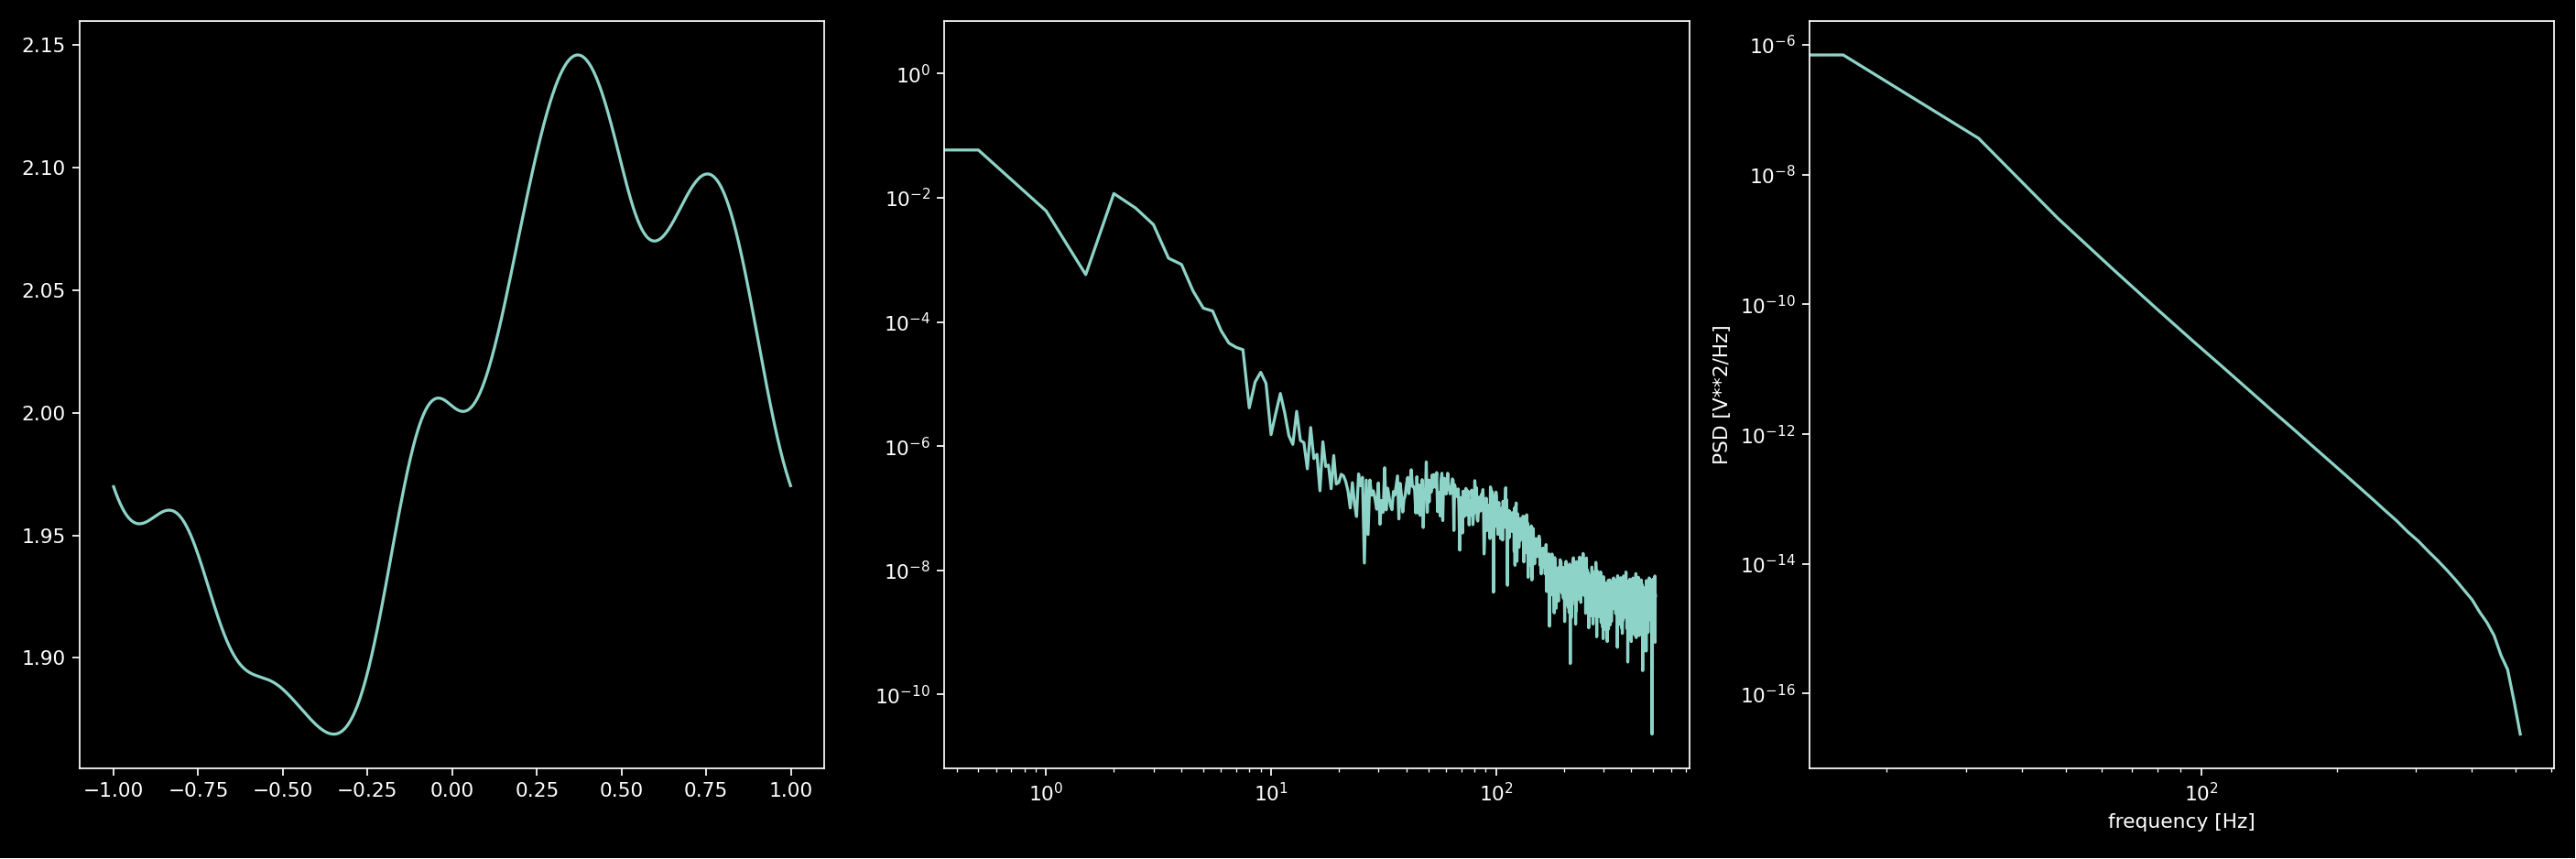

In [235]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain).type(dtype).to(device)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0]).type(dtype).to(device)
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStates = []
# plot initial density field to show starting conditions
density = plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

## Running the simulation based on an RK4 time integrator

The actual simulation proceeds by calling the computeUpdate function that takes the current simulation state and returns (per particle) $\frac{du}{dt}$, $\frac{dx}{dt}$, $\rho$ and $p$.

Note that we use a summation density approach to have something straight forward to learn, computing $\frac{d\rho}{dt}$ would also be possible but using a summation density makes the initial sampling more straightforward.

The updates are then computed according to the normal RK4 time integration scheme:

$$
\begin{align}
k_1 &= f(t^n, y^n)\\
k_2 &= f\left(t^n + \frac{h}{2}, y^n + h \frac{k_1}{2}\right)\\
k_3 &= f\left(t^n + \frac{h}{2}, y^n + h \frac{k_2}{2}\right)\\
k_4 &= f\left(t^n + h, y^n + h k_3\right)
\end{align}
$$

With $y^n = u_i^t$, i.e., we only update the velocities so that this becomes a first order PDE. Accordingly, we can then compute the new velocities and positions (using the updated velocity) as:
$$
\begin{align}
u_i^{n+1} &= u_i^n + \frac{h}{6}\left(k_1 + k_2 + k_3 + k_4\right)\\
x_i^{n+1} &= x_i^n + h u_i^{n+1}\\
t^{n+1} &= t^n + h
\end{align}
$$
with $h=dt$

<IPython.core.display.Javascript object>


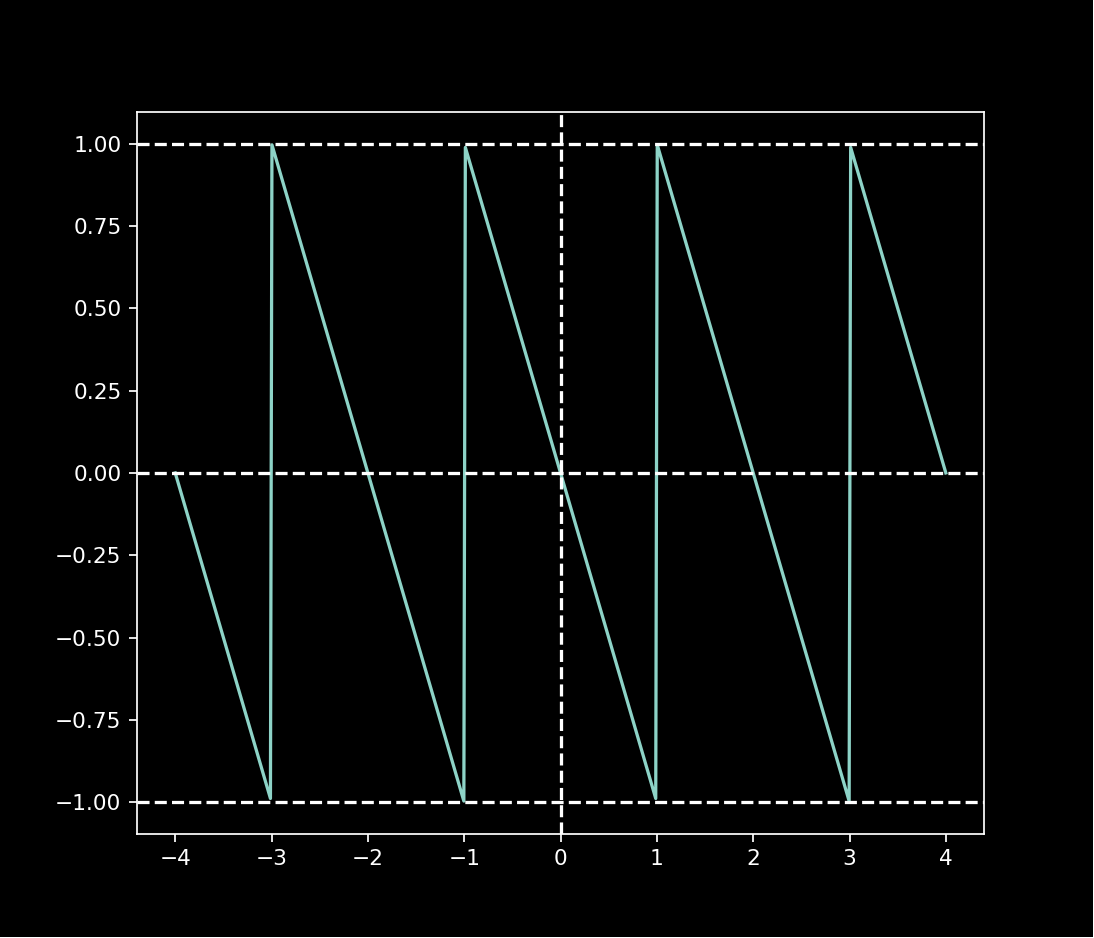

In [196]:
fig, axis = plt.subplots(1, 1, figsize=(7,6), sharex = False, sharey = False, squeeze = False)
x = torch.linspace(-4,4,511)
fx = torch.min(-1 - x, torch.min(-1 -x + 2, -1 - x - 2))
fx = 0 - x
fx = torch.remainder(fx + 1, 2) - 1
axis[0,0].plot(x, fx)

axis[0,0].axvline(0, ls = '--')
axis[0,0].axhline(0, ls = '--')
axis[0,0].axhline(-1, ls = '--')
axis[0,0].axhline(1, ls = '--')

tensor([[   0,    0,    0,  ..., 2047, 2047, 2047],
        [   0,    1,    2,  ..., 2045, 2046, 2047]])


<IPython.core.display.Javascript object>


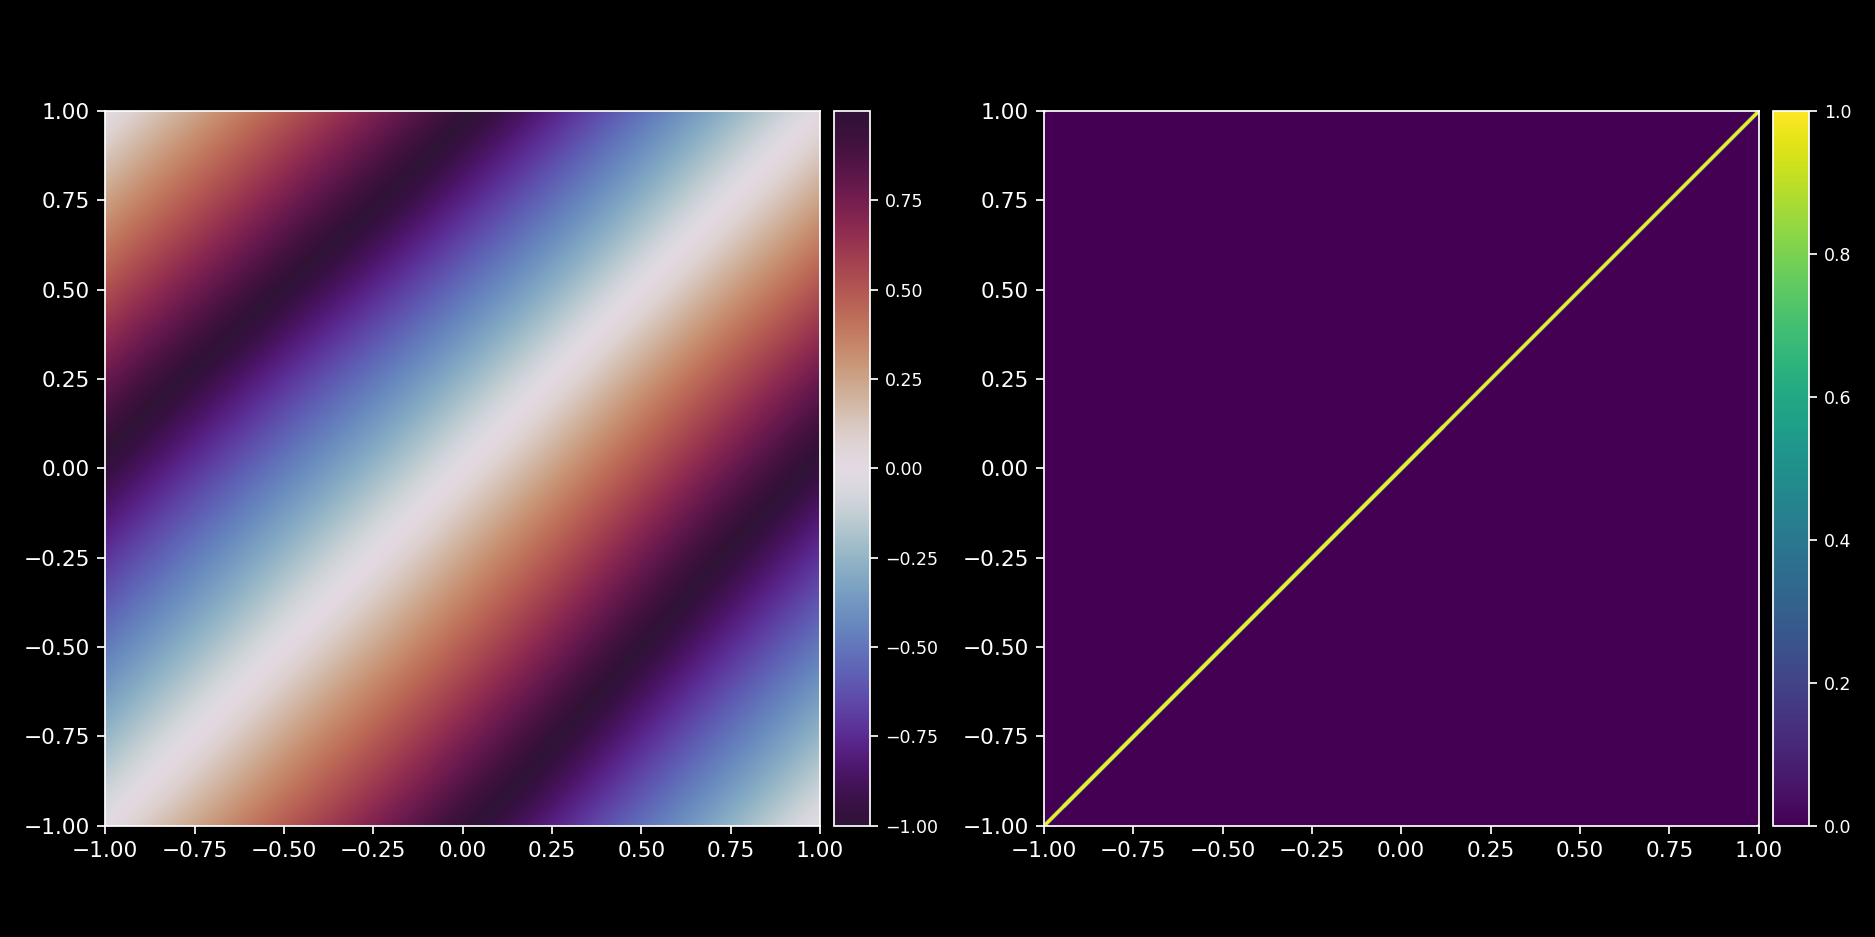

In [226]:
def periodicNeighborSearch(fluidPositions, particleSupport, minDomain, maxDomain):
    distanceMat = fluidPositions[:,None] - fluidPositions
    distanceMat = torch.remainder(distanceMat + minDomain, maxDomain - minDomain) - maxDomain
    neighs = torch.abs(distanceMat) < particleSupport
    n0 = torch.sum(neighs, dim = 0)
    indices = torch.arange(fluidPositions.shape[0])
    indexMat = indices.expand(fluidPositions.shape[0], fluidPositions.shape[0])
    j, i = indexMat[neighs], indexMat.mT[neighs]
    distances = -distanceMat[neighs]
    directions = torch.sign(distances)    
    return torch.vstack((i, j)), torch.abs(distances)  / particleSupport, directions

neighs, distances, directions = periodicNeighborSearch(fluidPositions, particleSupport, minDomain, maxDomain)
print(neighs)
# print(indexMat[neighs], indexMat.mT[neighs])

# print(n0, torch.min(n0), torch.max(n0), torch.median(n0))

# print(torch.abs(distanceMat) < particleSupport)
distanceMat = fluidPositions[:,None] - fluidPositions
distanceMat = torch.remainder(distanceMat + minDomain, 2) - maxDomain
neighs = torch.abs(distanceMat) < particleSupport
n0 = torch.sum(neighs, dim = 0)
indices = torch.arange(fluidPositions.shape[0])
indexMat = indices.expand(fluidPositions.shape[0],fluidPositions.shape[0])
j, i = indexMat[neighs], indexMat.mT[neighs]
distances = -distanceMat[neighs]
directions = torch.sign(distances)    
# return torch.vstack((i,j)), distances, directions

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)


im = axis[0,0].imshow(distanceMat[:,:].flip(1), cmap = 'twilight_shifted', extent = [-1,1,-1,1], interpolation = 'nearest')
im = axis[0,0].imshow(distanceMat[:,:].flip(1), cmap = 'twilight_shifted', extent = [-1,1,-1,1], interpolation_stage = 'rgba')
axis[0,0].axis('equal')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
GTcbar = fig.colorbar(im, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8)

im = axis[0,1].imshow(neighs[:,:].flip(1), cmap = 'viridis', extent = [-1,1,-1,1])
axis[0,1].axis('equal')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="5%", pad="2%")
GTcbar = fig.colorbar(im, cax=cax1,orientation='vertical')
GTcbar.ax.tick_params(labelsize=8) 

fig.tight_layout()




In [175]:
print(j)
print(jRef)

tensor([   0,    1,    2,  ..., 2045, 2046, 2047])
tensor([2046, 2047,    0,  ..., 2041, 2042, 2043])


In [216]:
ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
#  2. Find neighborhoods of all particles:
fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)

In [217]:
iRef, jRef = fluidNeighbors
print(torch.sort(iRef)[0])
print(torch.sort(i)[0])
print(torch.sum(torch.sort(iRef)[0] - torch.sort(i)[0] != 0))

print(torch.sort(jRef)[0])
print(torch.sort(j)[0])
print(torch.sum(torch.sort(jRef)[0] - torch.sort(j)[0] != 0))

tensor([   0,    0,    0,  ..., 2047, 2047, 2047])
tensor([   0,    0,    0,  ..., 2047, 2047, 2047])
tensor(0)
tensor([   0,    0,    0,  ..., 2047, 2047, 2047])
tensor([   0,    0,    0,  ..., 2047, 2047, 2047])
tensor(0)


In [227]:
index = 1024

jargs = torch.argsort(j[i==index])
jrefargs = torch.argsort(jRef[iRef == index])

print(torch.abs(distances)[i == index][jargs])
print(fluidRadialDistances[iRef == index][jrefargs])
print(directions[i == index][jargs])
print(fluidDistances[iRef == index][jrefargs])

print(torch.sum(torch.abs(distances)[i == index][jargs] / particleSupport - fluidRadialDistances[iRef == index][jrefargs]))
print(torch.sum(directions[i == index][jargs] - fluidDistances[iRef == index][jrefargs]))

tensor([0.0078, 0.0068, 0.0059, 0.0049, 0.0039, 0.0029, 0.0020, 0.0010, 0.0000,
        0.0010, 0.0020, 0.0029, 0.0039, 0.0049, 0.0059, 0.0068, 0.0078])
tensor([0.9998, 0.8748, 0.7498, 0.6249, 0.4999, 0.3749, 0.2499, 0.1250, 0.0000,
        0.1250, 0.2499, 0.3749, 0.4999, 0.6248, 0.7498, 0.8747, 0.9997])
tensor([-1., -1., -1., -1., -1., -1., -1., -1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.])
tensor([-1., -1., -1., -1., -1., -1., -1., -1.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.])
tensor(1.2636e-05)
tensor(0.)


In [236]:
# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
#     fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    fluidNeighbors, fluidRadialDistances, fluidDistances = periodicNeighborSearch(fluidPositions, particleSupport, minDomain, maxDomain)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0)**2 * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionAlpha, diffusionBeta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
#     fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

In [237]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), dudt_k1, dudt_k2, dudt_k3, dudt_k4, fluidAreas]))
    # time integration using RK4 for velocity
#     fluidVelocities = fluidVelocities + dt * dudt_k1 # semi implicit euler mode
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
#     fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
#     fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/256 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


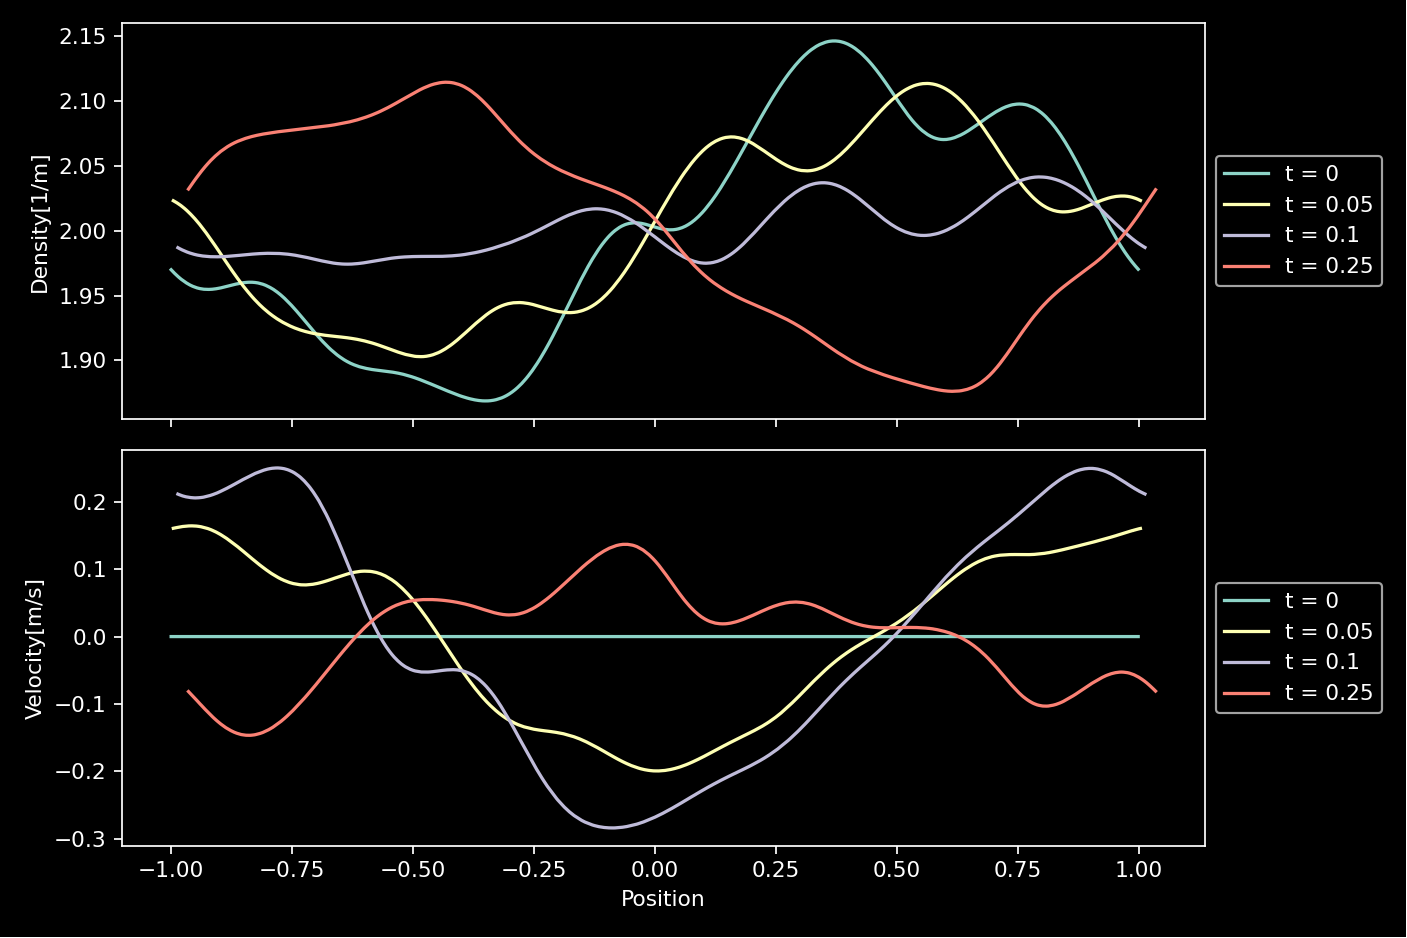

<IPython.core.display.Javascript object>


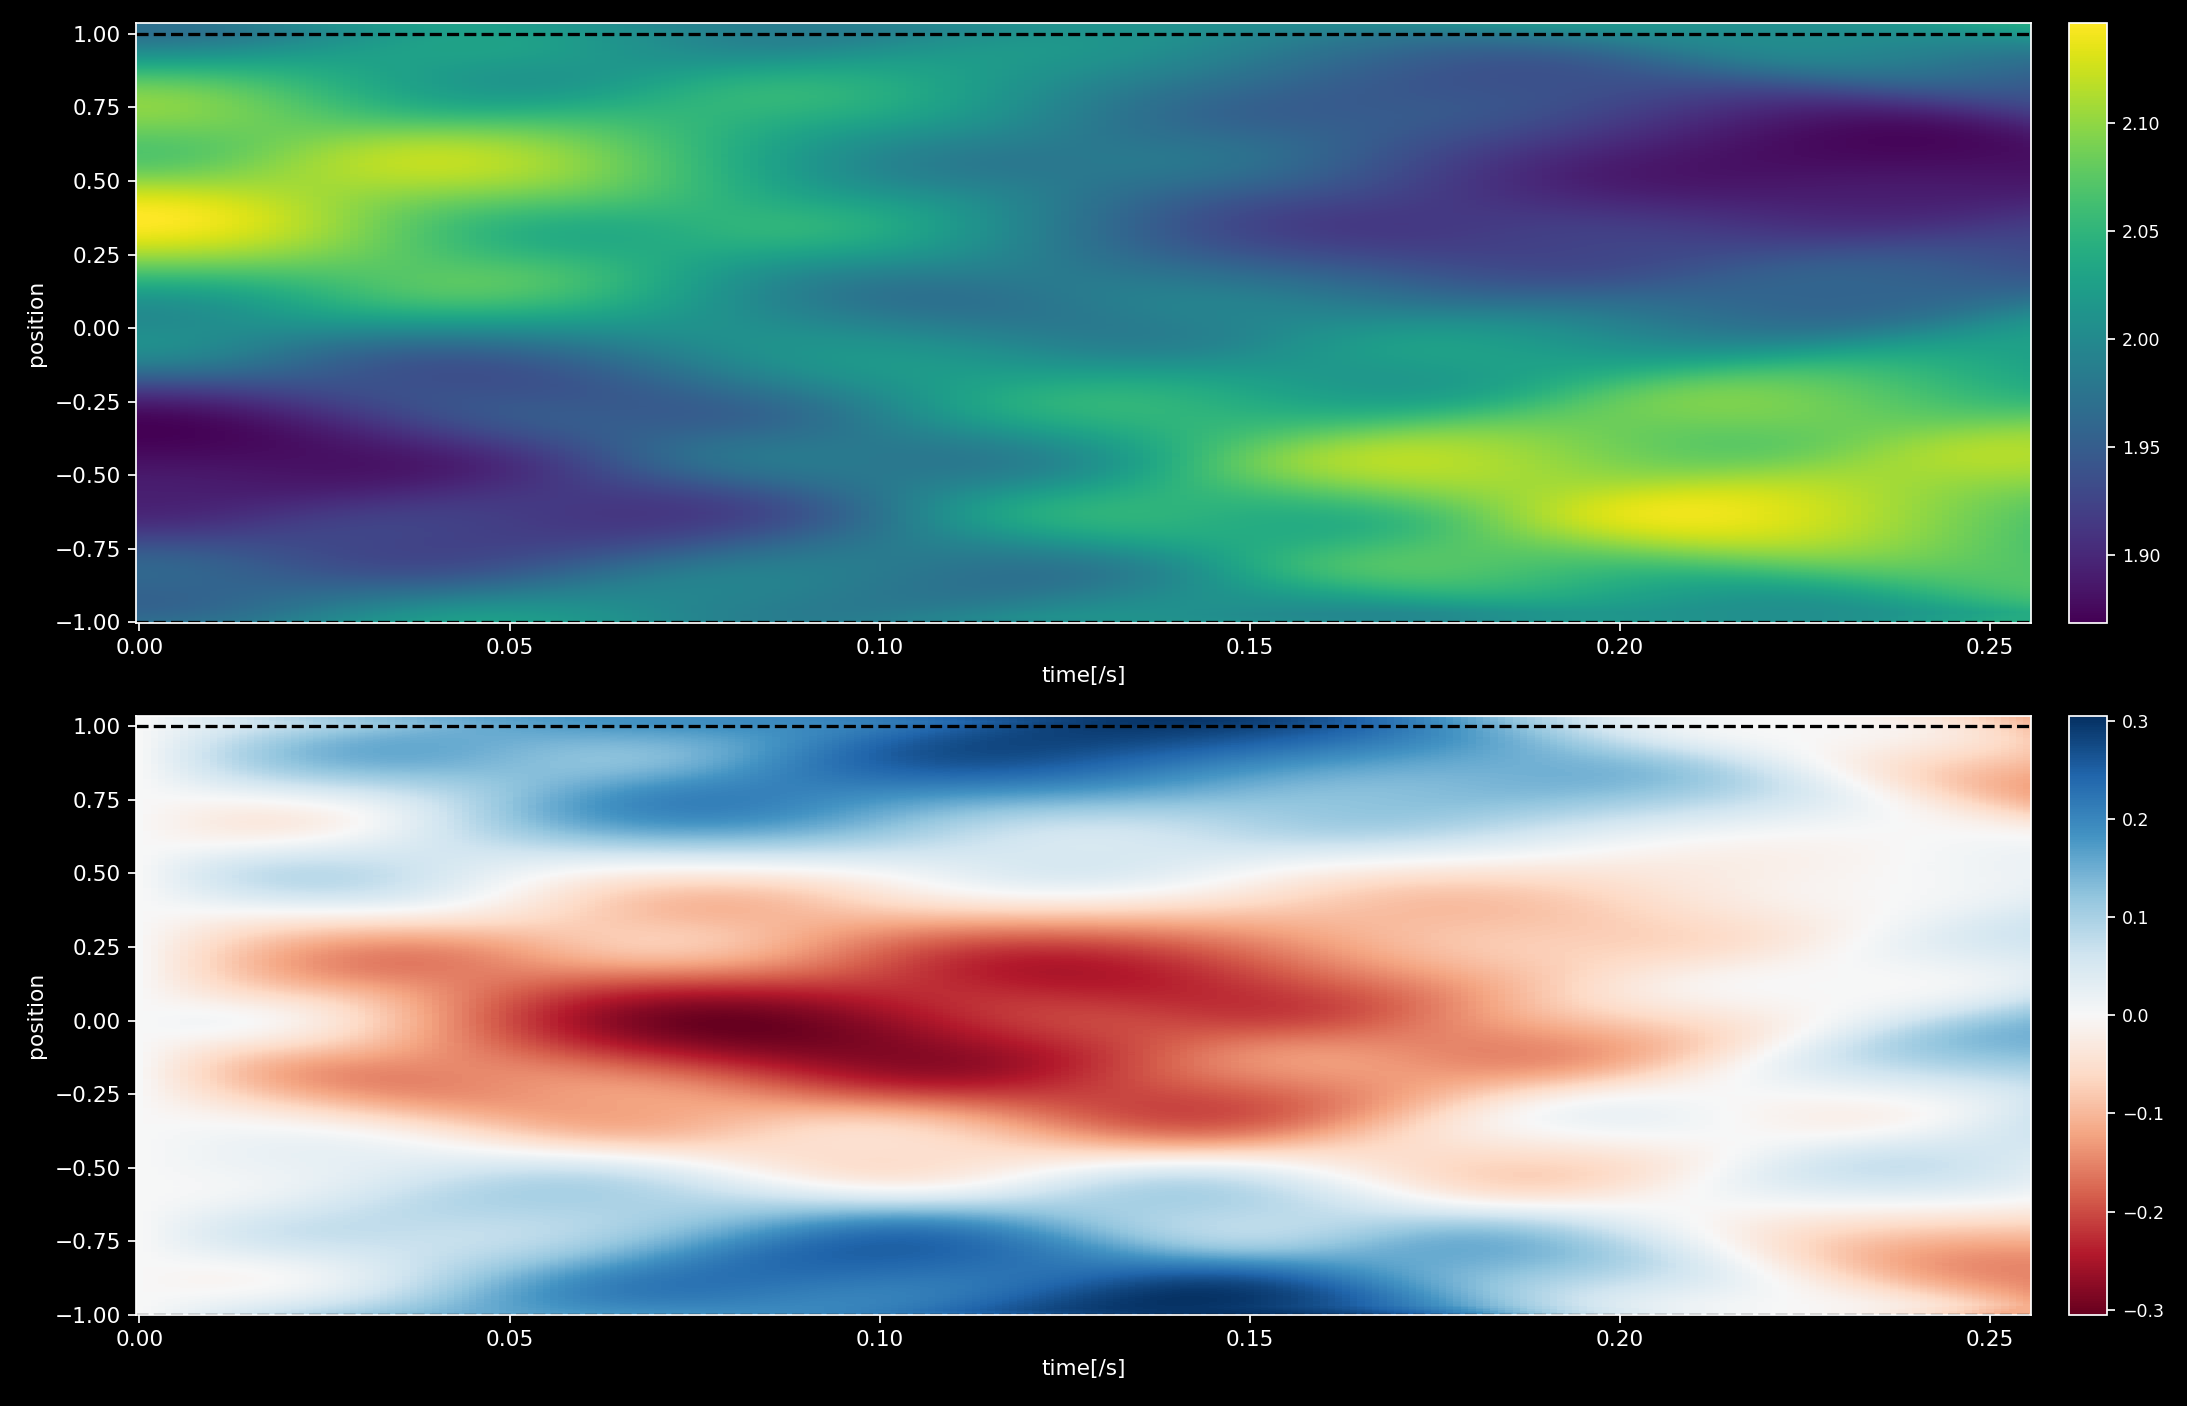

In [238]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250]) # This plots the simulation at the given timesteps, useful to see the behavior in detail, e.g., to check if any ripples exist that should not be there
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps) # Plots the entire simulation run with time on the y-axis as a pseudo 2D plot.

## Setup the Dataset and general functions for the NN
With the simulation done we  can now setup the simulation data as a dataset. To split the dataset into training and testing we exclude the last _ignoredTimesteps_ steps of the simulation in the training and use them exclusively for testing. For sampling we use a batch_sampler, i.e., a sample that returns 4 timestep indices (based on the _batchSize_ of 4), which are then used to compute the gradients for the NN as the mean across the 4 separate timesteps to improve training stability. This cell also sets up functions that determine the ground truth, in this case density, create a feature vector (in this case all ones) and a function that determines the loss. The loss here is an MSE term as MRSE is often times less stable due to the way the square root changes gradients for small values.

__Note:__ In a more generic scenario the dataset should include multiple simulations and not just one.

In [8]:
ignoredTimesteps = 256
batchSize = 4 # training batch size
# Training done on all timesteps except the last ignoredTimesteps
timestamps = np.arange(0,simulationStates.shape[0] - ignoredTimesteps)
testBatch = np.arange(len(simulationStates) - ignoredTimesteps, len(simulationStates))

# create pytorch dataloader (via pytorch geometric for convenience)
dataLoader = DataLoader(timestamps, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

def getGroundTruth(bdata, stacked, simulationStates):
    gt = [simulationStates[i,2,:] for i in bdata] # Learning Density
    groundTruth = torch.hstack(gt)[:,None]
    return groundTruth
def getFeatures(stackedPositions, stackedAreas, stackedVelocities, stackedUpdates):
    features = torch.ones_like(stackedAreas)    
    return features   
def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE

## Setup Hyperparameters and then initialize the NN model

Next we need to setup the hyperparameters for the neural network:

Parameter | Default | Meaning
---|---|---
lr | 1e-1 | The initial learning rate of the simulation
epochs | 5 | The number of epochs the network should be trained for
iterations | 1000 | The number of network updates per epoch
n | 15 | The number of parameters for the single layer network
basis | 'linear' | The interpolation basis used for the continuous convolution approach
computeBatchSize | 128 | Internal parameter, reduce this value to reduce memory requirements
windowFn | None | An inductive bias option that adds an additional convolution with a smooth window function after the network invocation
normalized | False | Determines if the network basis should be normalized. Note that 'linear' is already normalized by definition.

In [9]:
# Hyperparameters for the NN
lr = 1e-1 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
n = 15 # number of weights per continuous convolution
basis = 'linear' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = None # getWindowFunction('Wendland2_1D')
normalized = False # rbf normalization

Next we setup the neural network model, initialize the weights and create an optimizer for the model

Network has 16 parameters


<IPython.core.display.Javascript object>


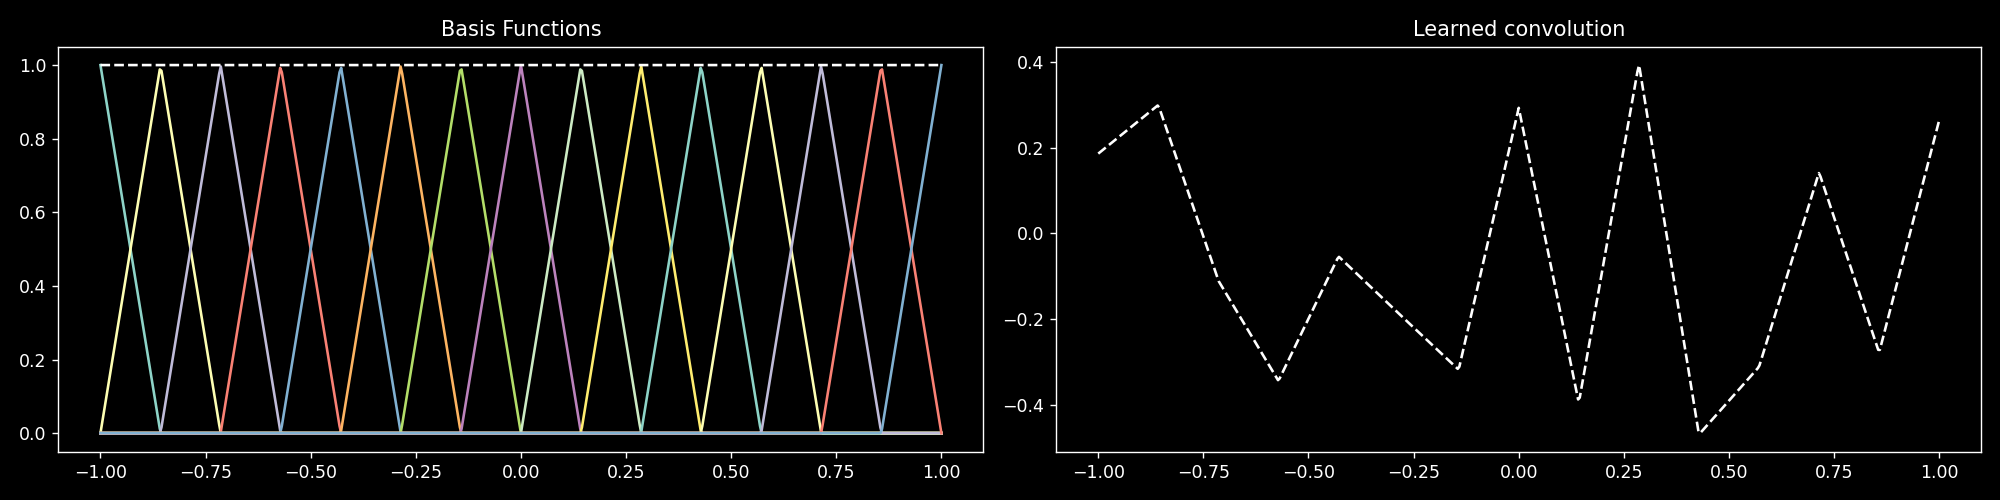

In [10]:
# Setup a single layer neural network using the RbfConv class
model = RbfConv(
            in_channels = 1, out_channels = 1,
                dim = 1, size = [n],
                rbf = basis,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = 'cartesian',
                batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized).to(device)
print('Network has', count_parameters(model), 'parameters')
# Initialize the weights. Note that the RbfConv initializes the weights as well based on some heuristics 
# but it is interesting to have this as an explicit step for trial and error
torch.nn.init.uniform_(model.weight,-.50,.50)
# plotRandomWeights(32, n, basis, 'Wendland2_1D') # This function plots a set of 32 randomly initialized convolutions to show what the randomness looks like
# It might also be useful to have explicitly initialized weights if we want to make assumptions, e.g., that the NN should learn a compact gaussian in this case
 # A non compact gaussian initialization
# weightFn = lambda x: np.exp(-(x * 2.5)**2)
# with torch.no_grad(): # Explicitl modifying the weights should be done within a no grad environment as these steps cannot be handled by autograd
#     model.weight[:,0,0] = torch.tensor(weightFn(np.linspace(-1,1,n)))
 # An initialization using the kernel function used in the SPH simulation we want to train for. This should be optimal.
# with torch.no_grad(): # Explicitl modifying the weights should be done within a no grad environment as these steps cannot be handled by autograd
#     model.weight[:,0,0] = kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport
# Plot the actual weights the network was initialized with, as well as the basis used for the network layer
plotWeights({k: v.cpu() for k, v in model.state_dict().items()}, basis, normalized)
# Create optimizer for the network
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)

## Training and Evaluation
Now we train the network and keep track of certain quantities during the training for visualization. Note that the learning rate is adjusted every epoch by a factor of 0.5 to improve learning performance.

In [11]:
# create progress bar and arrays to hold the learning progress
pb = tqdm(range(epochs * iterations))
lossArray = []
batches = []
weights = []
testing = []
# the actual learning process
for epoch in range(epochs):
    losses = []
    b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                    dataLoader, dataIter, batchSize, model, optimizer, \
                                    simulationStates, minDomain, maxDomain, particleSupport, \
                                    lossFunction, getFeatures, getGroundTruth, None,\
                                    train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)
    lossArray.append(l)
    batches.append(b)
    weights.append(w)
    if True: #epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


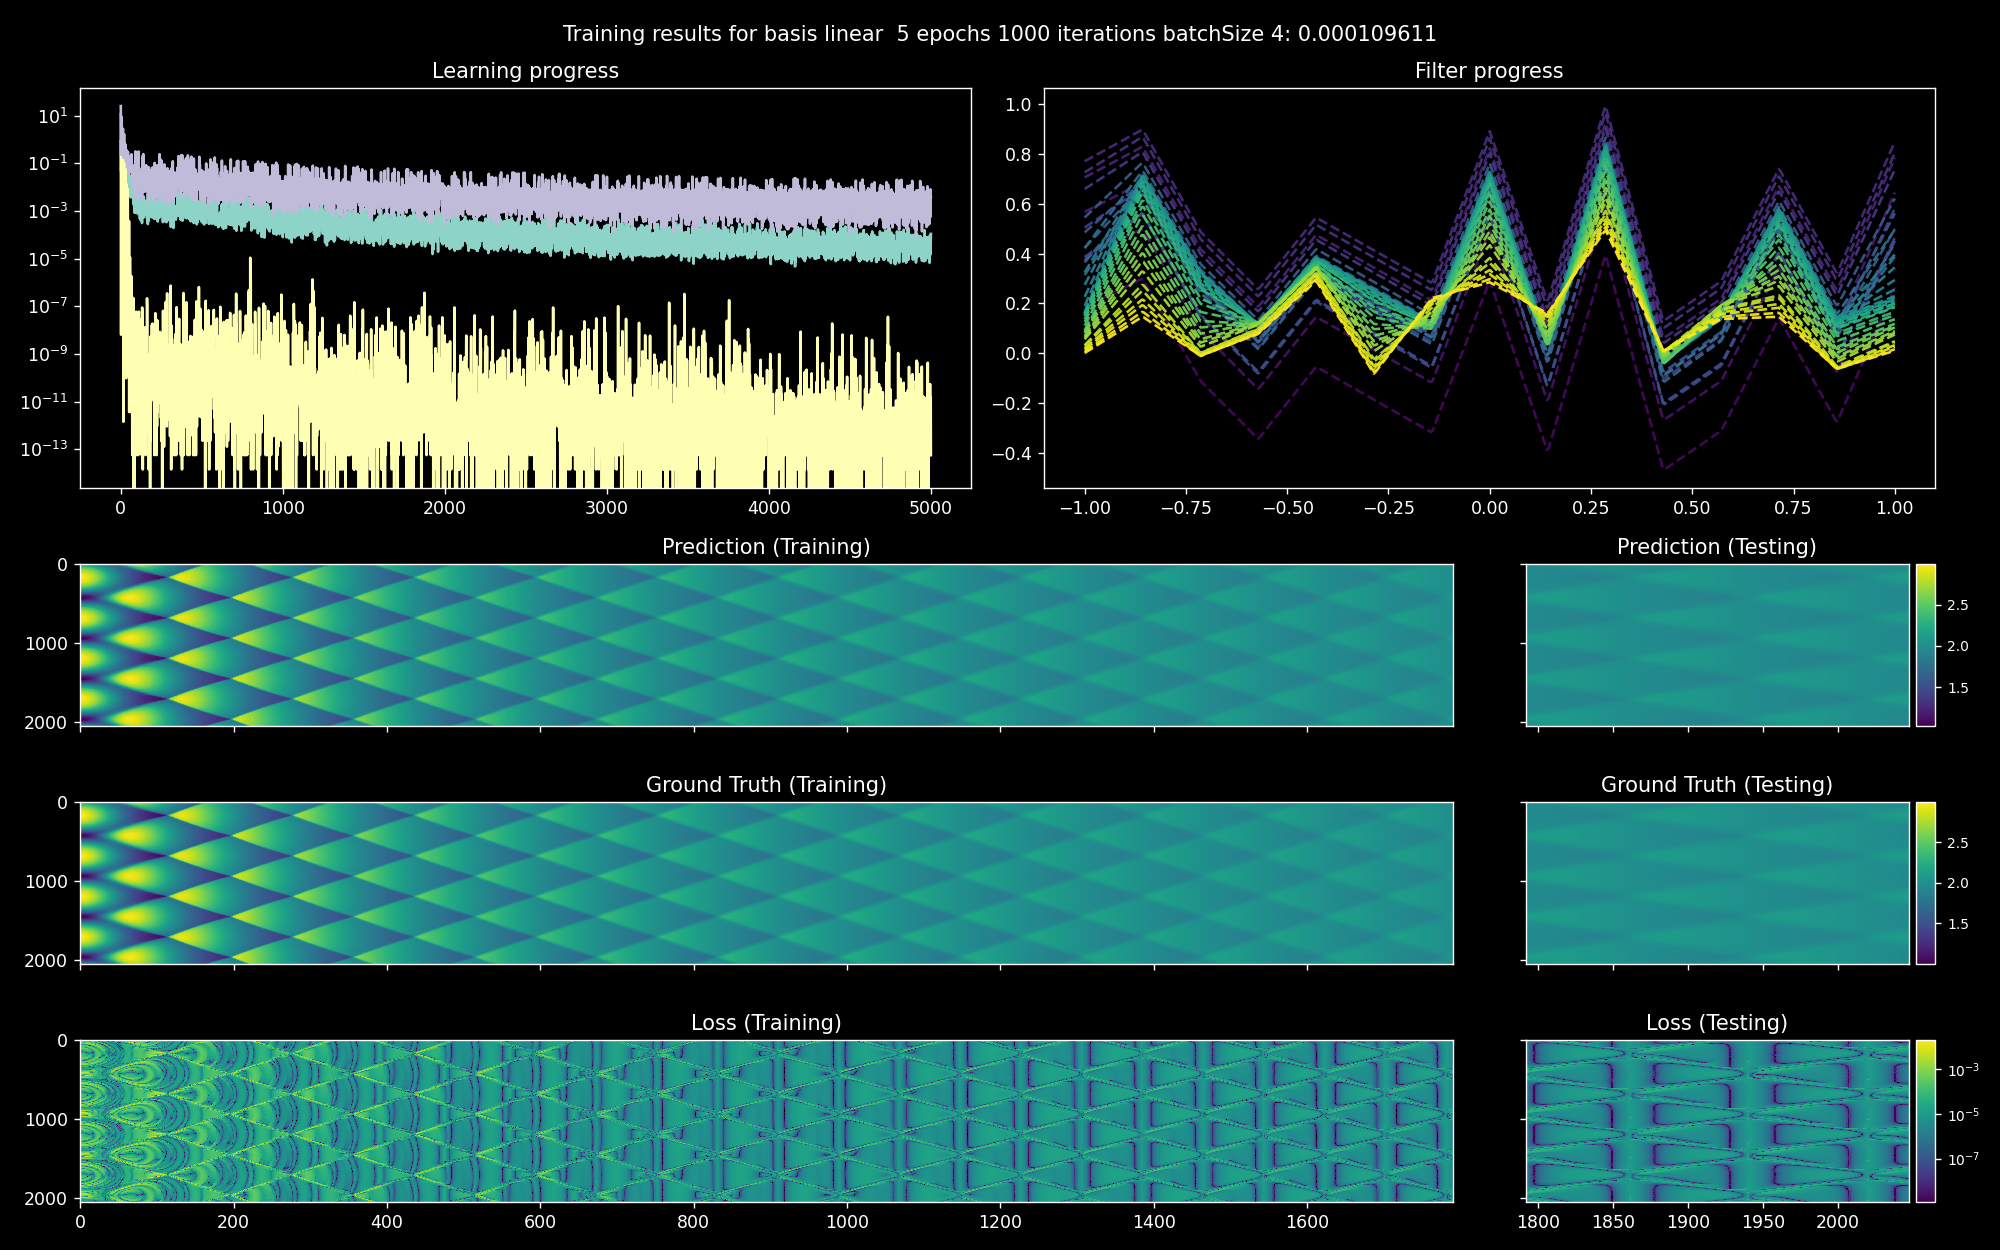

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
# This plot shows 4 separate interesting quantities:
# - The learning progress shows the training loss over all iterations by showing the maxium (purple), mean (teal) and minimum (yellow) loss per evaluation of a batch during training
# - The filter progress shows the convolutional filter the neural network learns color coded by iteration from early (purple) to late (yellow)
# - The prediction of the network for the entire training and testing dataset
# - The difference between the network prediction and the ground truth values
fig, axis = plotAll(model, device, weights, basis, normalized, iterations, epochs, numParticles, batchSize, lossArray, simulationStates, minDomain, maxDomain, particleSupport, timestamps, testBatch, lossFunction, getFeatures, getGroundTruth, None)

## Setting up a new simulation
Now that we have learned a neural network that can perform a task, we can integrate this task directly into the simulation loop. To do this we first setup a new simulation state as before. 


__Note:__ a different pdf here can be used to see how the network generalizes to unseen simulations as well.


<IPython.core.display.Javascript object>


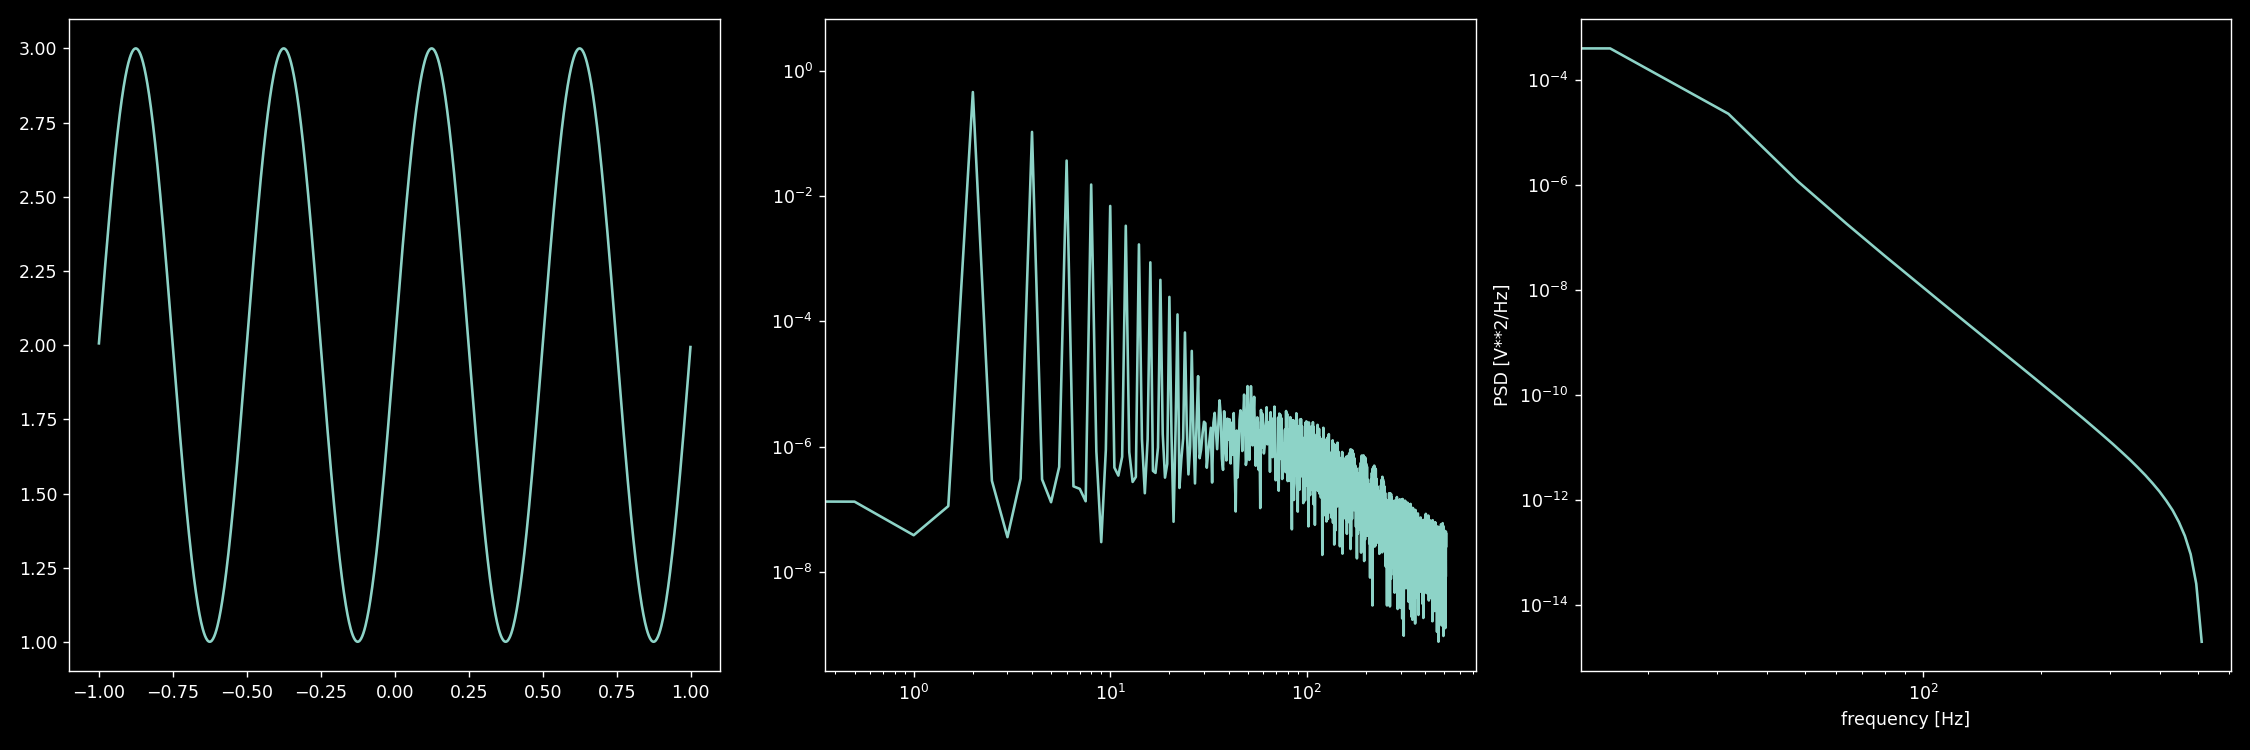

In [13]:
# Commen these lines in to evaluate the hybrid simulation using an unseen initial test case, e.g., a square profile in this case
# def pdf(x):
#     out = np.array(np.ones_like(x) * 2)
#     out[np.abs(x) > 1/3] = 1
#     return out

# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain).type(dtype).to(device)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0]).type(dtype).to(device)
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStatesML = []
# plot initial density field to show starting conditions
density = plotDensityField(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

## Including the NN into the simulation step:

Integrating the NN into the simulation can be done straight forwardly by first computing the feature vector based on the current state of the simulation and then simply calling the NN model to compute the densities instead of calling the SPH based density evaluation. The only non straight forward part here is that we need to reconstruct the signed distance between neighbors instead of the unsigned distance that is commonly used in SPH as our NN is (most likely) not symmetric.

In [14]:
# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdateML(model, fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------- #
    #  3. Compute \rho using the trained neural network
    features = getFeatures(fluidPositions, fluidAreas, fluidVelocities, None)
    with torch.no_grad():
        fluidDensity = model((features[:,None], features[:,None]), fluidNeighbors, fluidRadialDistances[:,None] * torch.sign(fluidDistances[:,None]))[:,0]
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------- #
        
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionAlpha, diffusionBeta, c0, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
#     fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

We can then run the simulation as before by simply calling computeUpdateML instead of computeUpdate.

In [15]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdateML(model, fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdateML(model, x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdateML(model, x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdateML(model, x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionAlpha, diffusionBeta, c0, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStatesML.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), dudt_k1, dudt_k2, dudt_k3, dudt_k4, fluidAreas]))
    # time integration using RK4 for velocity
#     fluidVelocities = fluidVelocities + dt * dudt_k1
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStatesML = torch.stack(simulationStatesML)


  0%|          | 0/2048 [00:00<?, ?it/s]

## Finally visualize the results

<IPython.core.display.Javascript object>


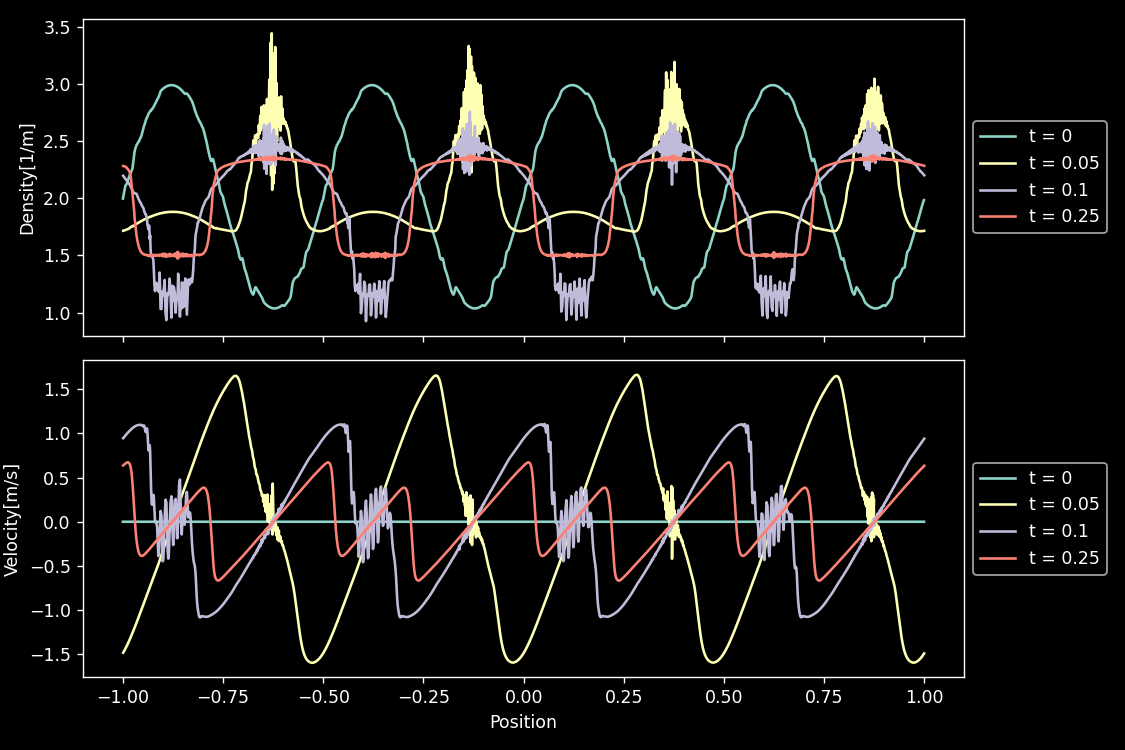

<IPython.core.display.Javascript object>


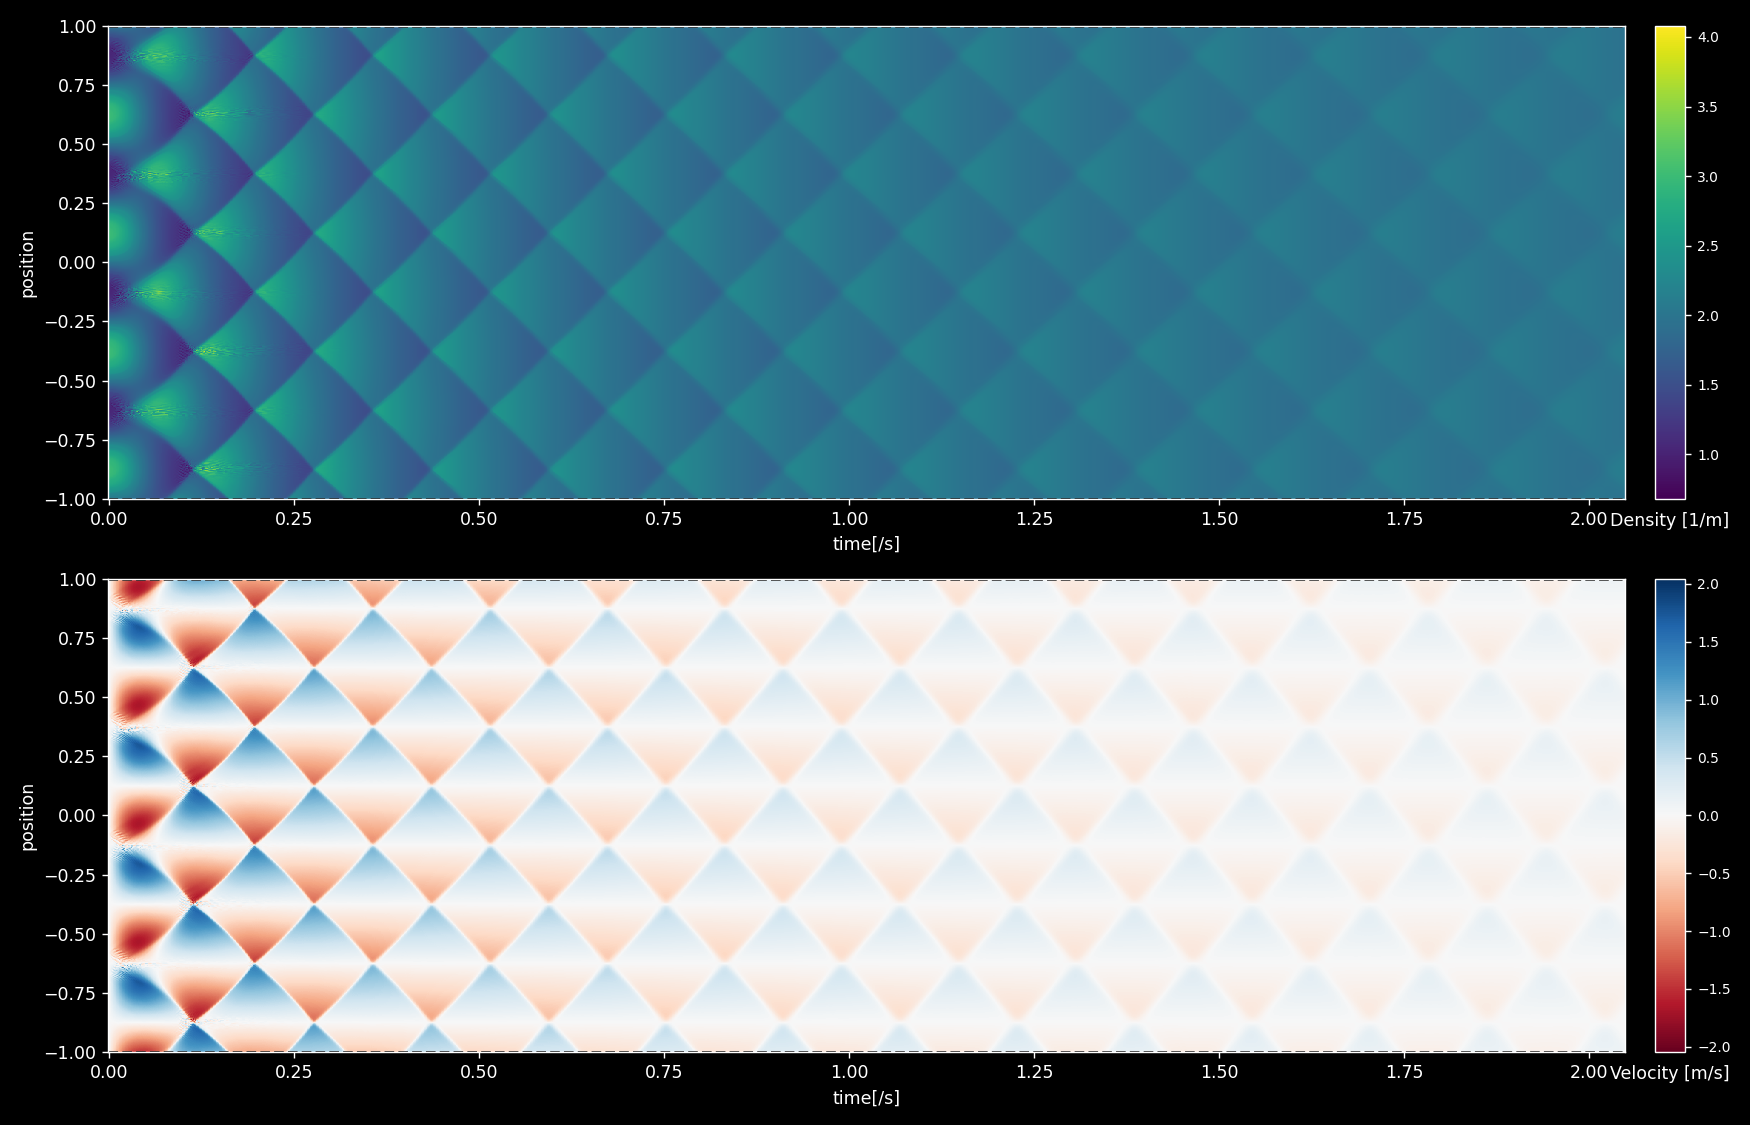

In [16]:
plotSimulationState(simulationStatesML, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 250])
regularPlot(simulationStatesML, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

If the same pdf was used to evaluate the hybrid model as was for the simulation, we can also visualize the differences directly by plotting the per particle errors for density and velocity

<IPython.core.display.Javascript object>


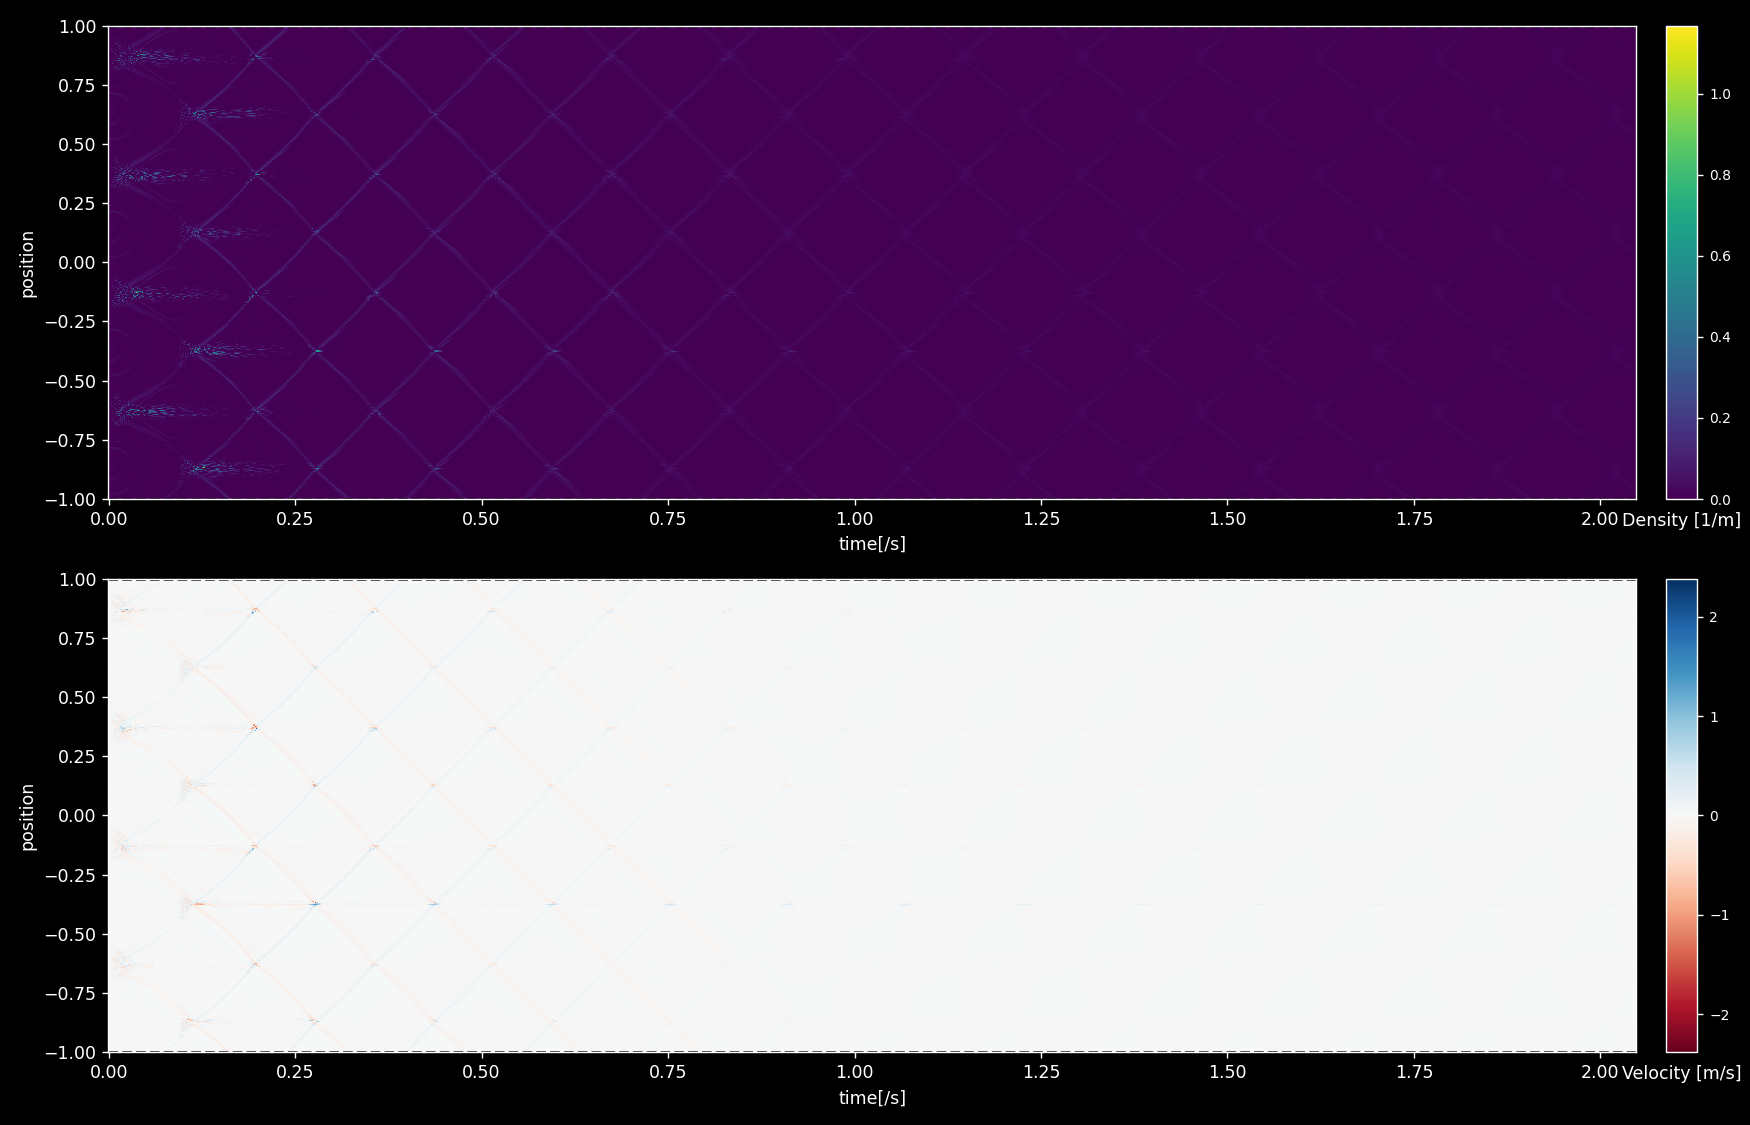

In [17]:
simulationStatesDiff = simulationStates - simulationStatesML
simulationStatesDiff[:,0] = simulationStates[:,0]

regularPlot(simulationStatesDiff, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)